# Данные 
В некотором *городе N* на каждом автобусе/троллейбусе/трамвае установлены GPS трекеры, которые с некоторым промежутком времени передают информацию о своем местоположении на специальный сервер. 

Данные для всех транспортных средства одного маршрута непрерывно записывались на протяжении недели, потом GPS координаты (широта и долгота) были спроецированы на плоскость с использованием [проекции Меркатора](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_%D0%9C%D0%B5%D1%80%D0%BA%D0%B0%D1%82%D0%BE%D1%80%D0%B0) и некоторого линейного преобразования. Эти данные записаны в файле **../data/transport_log.zip** в виде:

>    **1447037729**&nbsp;&nbsp;&lt;tab&gt;&nbsp;&nbsp;**3054.619968**&nbsp;&nbsp;&lt;tab&gt;&nbsp;&nbsp;**2409.828279**&nbsp;&nbsp;&lt;tab&gt;&nbsp;&nbsp;**570d8**

поля разделены табуляцией. Здесь:
- **1447037729** - [UNIX-время](https://ru.wikipedia.org/wiki/UNIX-%D0%B2%D1%80%D0%B5%D0%BC%D1%8F), которое без труда можно преобразовать во что-то разумное с помощью стандартной библиотеки [Python](https://docs.python.org/2/library/datetime.html#datetime.date.fromtimestamp).
- **3054.619968** - координата "x"
- **2409.828279** - координата "y"
- **570d8** - уникальный идентификатор транспортного средства, от которого получен сигнал. 

Маршрут автобосов "туда" не совпадает с маршрутом "обратно". Известно, что в направлении, которое мы назовем "туда"  первая остановка имеет координаты:

>   **(11038.08464497, 8253.17542416)**

последняя:

>   **(283.08479678,  163.45489494)**


# Задачи

- Отобразить все точки на плоскости

In [147]:
import zipfile
import io
import numpy as np
from datetime import datetime
import pandas as pd
X = None
with zipfile.ZipFile('/Users/Nikita/classification-2016/data/transport_log2.zip', 'r') as zf:
    with zf.open('transport_log.txt', 'r') as f:
        f_unicide = io.TextIOWrapper(f, 'utf-8')
        
        X = np.array([(datetime.utcfromtimestamp(int(l.strip().split('\t')[0])),
                       float(l.strip().split('\t')[1]), 
                       float(l.strip().split('\t')[2]),
                       l.strip().split('\t')[3]) for l in f_unicide])

bus_set = set([x for x in X[:, 3]])

In [148]:
X_pd = pd.DataFrame(X, columns=['datetime', 'X', 'Y', 'busID'])

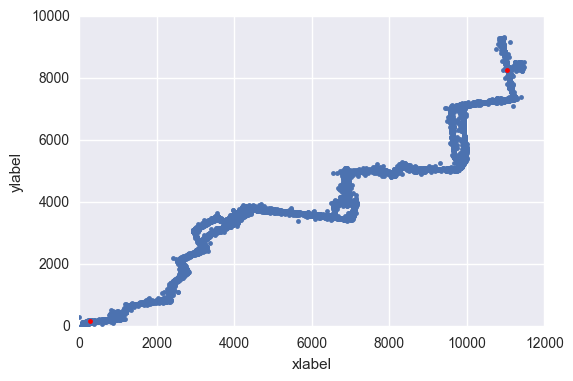

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

start = (11038.08464497, 8253.17542416)
end = (283.08479678, 163.45489494)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('xlabel')
ax.set_ylabel('ylabel')

plt.plot(X[:,1], X[:, 2], '.')
plt.plot(start[0], start[1], '.', c='r')
plt.plot(end[0], end[1], '.', c='r')
plt.show()

- Отобразить в bar plot зависимость числа точек от часа (0-23). По оси "X" столбцы с метками 0-23, по оси "Y" - число соответствующих точек в логе.

<Container object of 24 artists>

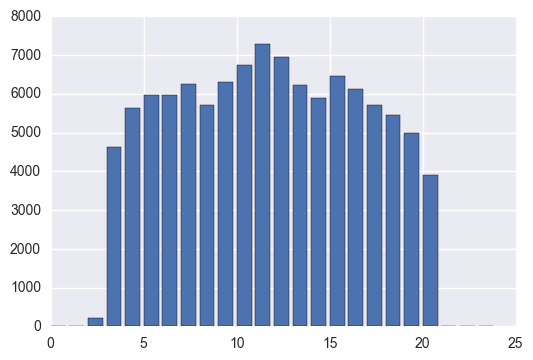

In [150]:
from collections import Counter
t_arr = Counter()
for i in range(0, 24):
    t_arr[i] += len([t for t in [x.time().hour == i for x in X[:, 0]] if t])

plt.bar(t_arr.keys(), t_arr.values())

In [151]:
b_arr = Counter()
for bus in bus_set:
    b_arr[bus] = len([b for b in X[:, 3] if bus == b])

print(X[1])

[datetime.datetime(2015, 11, 9, 2, 55, 29) 3054.619968 2409.828279 '570d8']


- Выделить из лога подпоследовательности, соответствующие гарантировано полным маршрутам в направлении "туда". То есть автобус должен пройти первую остановку с обозначенными выше координатами, затем последнюю.

340


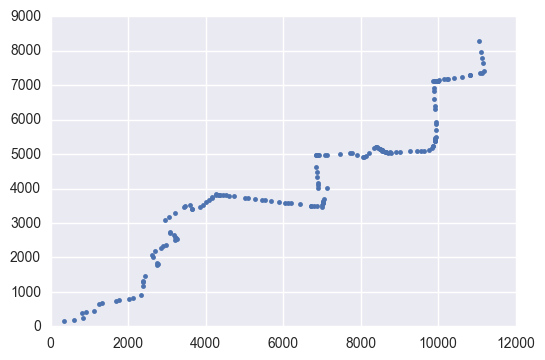

In [163]:
routes = []
bus_set = set(X[:, 3])

def find_path(df, s, e):
    for i in s:
        j = e[np.argmax(e>i)]
        route = df[i : j]
        if route.any():
            routes.append(route)

for bus in bus_set:
    bf = X[X[:, 3] == bus]
    s_app = np.where((bf[:, 2] >= 8200) & (bf[:, 2] <= 8280))[0]
    e_app = np.where(bf[:, 1] <= 284)[0]
    find_path(bf, s_app, e_app)

n_routes = len(routes)
print(n_routes)
plt.plot(routes[1][:, 1], routes[1][:, 2], '.')

- По данным из предыдущего пункта построить приближенный маршрут в виде кусочно-линейно функции, причем линейные компоненты должны иметь одинаковую длину. Отобразить таким образом, чтобы каждый участок имел цвет в зависимости от средней скорости прохождения участка. 

In [153]:
routes_df = [pd.DataFrame(d) for d in routes]

In [154]:
all_routes = pd.concat(routes_df)

In [155]:
x_max = all_routes[all_routes[1] > 11037][1].mean()
x_min = all_routes[all_routes[1] < 303][1].mean()
y_max = all_routes[all_routes[2] > 8250][2].mean()
y_min = all_routes[all_routes[2] < 164][2].mean()

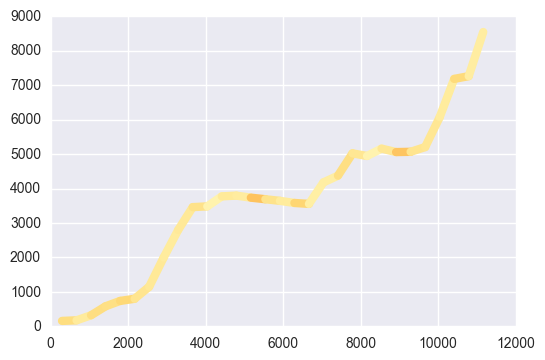

In [166]:
import math as m
import matplotlib
import matplotlib.cm as cm

n = 30
x = np.linspace(x_min, x_max, n)

speed = []
ys = []
ys.append(y_min)

for i in range (len(x)-1):
    x0 = x[i]
    x1 = x[i+1]
    s = []
    y = []
    for route in routes:
        r = route[(route[:, 1] > x0) & (route[:, 1] < x1)]
        if r.shape[0] < 2:
            continue
        if i != len(x)-2:
            y.extend(r[:, 2])
        t = r[-1][0] - r[0][0]
        d = m.sqrt((r[-1][1] - r[0][1])**2 + (r[-1][2] - r[0][2])**2)
        s.append(d/t.seconds)
    speed.append(sum(s)/len(s))
    if i != len(x)-2:
        ys.append(sum(y)/len(y))
ys.append(y_max)

norm_speeds = speed / np.linalg.norm(speed) 
cms = []

for i in range(len(x)-1):
    c = cm.YlOrRd(norm_speeds[i])
    cms.append(c)
    plt.plot([x[i],x[i+1]], [ys[i],ys[i+1]], color = c, linewidth=6)
